필요한 패키지를 가져옵니다.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.datasets import mnist

숫자 손글씨 데이터셋을 불러옵니다. 

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print('x_train shape : ' + str(x_train.shape))
print('y_train shape : ' + str(y_train.shape))
print('x_test shape : ' + str(x_test.shape))
print('y_test shape : ' + str(y_test.shape))

11501568/11490434 [==============================] - 1s 0us/step
x_train shape : (60000, 28, 28)
y_train shape : (60000,)
x_test shape : (10000, 28, 28)
y_test shape : (10000,)


테스트할 샘플 하나를 살펴봅니다.

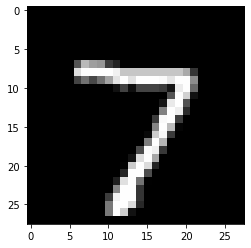

In [ ]:
plt.imshow(x_test[0], cmap='gray')

인공지능 모델이 이 이미지를 입력받았을 때, 해당하는 숫자를 출력할 수 있도록 만드는 것이 목표입니다. 우리는 y_test 라벨값도 가지고 있어서 바로 확인은 할 수 있으나, 모델 학습 시에는 사용이 되지 않으며, 시험 평가할 때만 사용됩니다.

In [ ]:
print(y_test[0])

7


모델 학습에 용이하도록 다음과 같이 데이터 전처리를 수행합니다.

*   데이터 전처리
    * 3차원(샘플수, 세로, 가로)를 2차원(샘플수, 벡터수)으로 변경
    * 정수를 실수로 변경
    * 0 ~ 255 사이의 수치를 0.0 ~ 1.0 사이로 정규화 수행
*   라벨 전처리
    * 0 ~ 9 라벨에 대한 원핫인코딩 수행 



In [ ]:
x_train = x_train.reshape(60000, 784).astype('float32') / 255.0
x_test = x_test.reshape(10000, 784).astype('float32') / 255.0
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

모델은 다음과 같이 구성하였습니다.

* 입력: 1차원의 784개 벡터
* 출력: 10개 벡터
* 출력층의 활성화 함수: 소프트맥스
* 손실함수: categorical_crossentropy
* 최적화기: adam
* 평가 메트릭: accuracy


In [ ]:
model = Sequential([
    Dense(64, input_dim=28*28, activation='relu'), 
    Dense(32, activation='relu'), 
    Dense(10, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

모델 네트워크 아키텍처 구성을 그려보겠습니다.

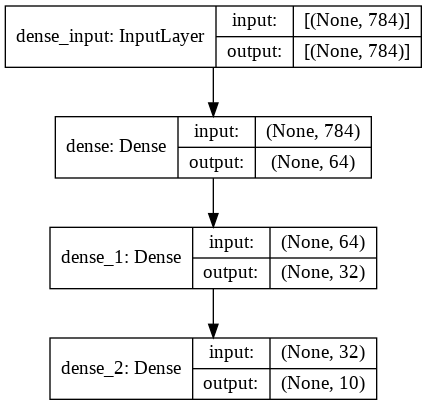

In [ ]:
plot_model(model, show_shapes=True)

모델을 학습시킬 때, validation_split 옵션을 두면 훈련셋 일부를 검증셋으로 설정할 수 있습니다. 0.2로 설정할 경우, 전체 훈련셋에서 20%를 검증셋, 나머지를 훈련셋으로 구성하여 학습합니다.

In [ ]:
hist = model.fit(x_train, y_train, 
                 validation_split=0.2, 
                 batch_size=32,
                 epochs=100)

학습 시 매 에포크에 해당하는 훈련셋과 검증셋에 대한 손실값과 평가 메트릭 수치를 확인할 수 있습니다. 이를 시각화시키면 오버피팅 여부를 한 눈에 확인할 수 있습니다.

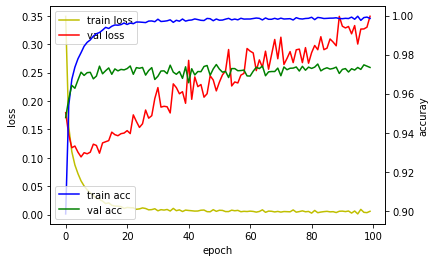

In [ ]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

오버피팅이 10 에포크 이전에 발생했더라도 100 에포크까지 학습을 시켰으므로 현재 모델은 오버피팅이 되어 있는 상태입니다. 오버피팅이 되지 않은 모델을 확보하기 위해는 아래 세 가지 방법을 사용할 수 있습니다. 

1. 오버피팅이 되는 에포크를 확인하였다면, 오버피팅 전의 에포크 만큼 모델을 학습시킵니다.
2. 콜백함수를 사용하여, 오버피팅이 감지되면 조기 중단을 시키도록 합니다.
3. 콜백함수를 사용하여, 매 에포크마다 검증셋의 손실값을 체크한 후, 이전 손실값보다 낮은 경우 모델을 파일로 저장합니다. 즉 학습 종료가 되면, 파일에 저장된 모델은 손실값이 가장 낮을 때의 가중치를 가지고 있습니다.

1번 방법은 두 번 학습을 시켜야하고, 2번 방법은 더 학습이 가능했음에도 설정된 오버피팅 감지 조건에 의해 조기 중단이 될 수도 있으므로, 이후 실습에서는 주로 3번 방법을 사용하도록 하겠습니다.

모델 정의부터 컴파일, 콜백함수 정의, 모델 학습까지의 코드는 아래와 같습니다. 다음부터는 두 번 학습할 필요없이 아래 코드로 한 번만 수행합니다.

In [ ]:
from scipy import ndimage
def data_augmentation(images, labels): # agumentation된 이미지랑 label을 저장할 빈 리스트 생성 
  aug_images = [] 
  aug_labels = [] 
  for x, y in zip(images, labels): 
    aug_images.append(x) # 리스트에 먼저 오리지널 이미지와 레이블을 저장 
    aug_labels.append(y) 
    bg_value = np.median(x) 
    # rotation이나 shift 후 생기는 이미지의 빈 공간을 채우기 위한 back ground value값 설정 
    # for문을 4번돌려 데이터를 4배로 불림 
    # 오리지널 데이터를 한 번 저장하고 여기서 4배의 데이터를 만들어내므로 총 5배의 데이터로 증가한다. 
    for _ in range(3):
      angle = np.random.randint(-15, 15, 1) # -15~15사이의 랜덤한 수를 뽑아서 그 각도로 rotation 
      rot_img = ndimage.rotate(x, angle[0], reshape=False, cval=bg_value) # cval옵션으로 빈공간을 채움 
      # 앞서 rotation시킨 데이터를 다시 shift시킴 
      shift = np.random.randint(-2, 2, 2) # -2px~2px사이의 값으로 shift, 숫자를 2개를 뽑아서 하나는 가로 방향, 하나는 세로 방향에 적용 
      shift_img = ndimage.shift(rot_img, shift, cval=bg_value) # rotation, shift 적용된 이미지를 리스트에 저장 
      aug_images.append(shift_img) 
      aug_labels.append(y) # 불린 데이터를 저장한 리스트를 np.array형태로 변환하여 리턴 
  aug_images = np.array(aug_images) 
  aug_labels = np.array(aug_labels) 
  return aug_images, aug_labels
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, y_train = data_augmentation(x_train, y_train)

x_train = x_train.reshape(-1, 784).astype('float32') / 255.0
x_test = x_test.reshape(10000, 784).astype('float32') / 255.0
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
x_train.shape

(240000, 784)

In [ ]:
from tensorflow.keras.layers import Flatten, Dropout
model = Sequential([
    Flatten(input_dim=28*28),
    BatchNormalization(),
    Dense(1024, activation='relu'), 
    BatchNormalization(),
    Dense(1024, activation='relu'), 
    BatchNormalization(),
    Dropout(0.2),
    Dense(2048, activation='relu'), 
    BatchNormalization(),
    Dense(4096, activation='relu'), 
    BatchNormalization(),
    Dropout(0.2),
    Dense(1024, activation='relu'), 
    BatchNormalization(),
    Dense(256, activation='relu'), 
    BatchNormalization(),
    Dense(10, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

checkpoint_callback = ModelCheckpoint("best_model.h5", 
                                      save_best_only=True, 
                                      monitor="val_loss")

hist = model.fit(x_train, y_train, 
                 validation_split=0.2, 
                 batch_size=64,
                 epochs=200,  
                 callbacks=[checkpoint_callback])

Epoch 1/200
6000/6000 [==============================] - 38s 6ms/step - loss: 0.1929 - accuracy: 0.9397 - val_loss: 0.1060 - val_accuracy: 0.9694
Epoch 2/200
6000/6000 [==============================] - 35s 6ms/step - loss: 0.0895 - accuracy: 0.9722 - val_loss: 0.0764 - val_accuracy: 0.9777
Epoch 3/200
6000/6000 [==============================] - 35s 6ms/step - loss: 0.0598 - accuracy: 0.9811 - val_loss: 0.0643 - val_accuracy: 0.9820
Epoch 4/200
6000/6000 [==============================] - 35s 6ms/step - loss: 0.0432 - accuracy: 0.9862 - val_loss: 0.0621 - val_accuracy: 0.9828
Epoch 5/200
6000/6000 [==============================] - 35s 6ms/step - loss: 0.0337 - accuracy: 0.9891 - val_loss: 0.0579 - val_accuracy: 0.9849
Epoch 6/200
6000/6000 [==============================] - 35s 6ms/step - loss: 0.0280 - accuracy: 0.9909 - val_loss: 0.0593 - val_accuracy: 0.9833
Epoch 7/200
6000/6000 [==============================] - 35s 6ms/step - loss: 0.0241 - accuracy: 0.9922 - val_loss: 0.0593 -

KeyboardInterrupt: ignored

이로서 현재 학습 과정 중 가장 낮은 검증셋의 손실값을 가진 모델이 "best_model.h5" 파일로 저장되었습니다.

파일로 저장된 모델을 로딩하여 시험셋으로 최종 평가를 수행합니다.

In [ ]:
# model = load_model("best_model.h5")

test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

313/313 [==============================] - 1s 3ms/step - loss: 0.0400 - accuracy: 0.9910
Test accuracy 0.9909999966621399
Test loss 0.04004194959998131


또한 시험셋으로 테스트한 결과를 제출하기 위해 모델 결과 파일을 저장합니다. 출력이 10개 클래스에 해당하는 벡터이므로, 분류한 클래스 정보를 얻기 위해 가장 높은 값을 가진 인덱스 값을 가지고 옵니다. 이 인덱스가 클래스를 의미하며, 이 값을 파일로 저장합니다.

In [ ]:
y_pred = model.predict(x_test)
y_pred = y_pred.argmax(axis=-1)
np.savetxt('y_pred.csv', y_pred, fmt='%d')

In [ ]:
y_pred = model.predict(x_test)
y_pred = y_pred.argmax(axis=-1)
np.savetxt('y_pred_' + str(test_acc) + '.csv', y_pred, fmt='%d')

In [ ]:
from tensorflow.keras.layers import Flatten, Dropout, LeakyReLU, Dense, BatchNormalization
model = Sequential([
    Flatten(input_dim=28*28),
    BatchNormalization(),
    Dense(1024, activation=LeakyReLU(alpha=0.3)), 
    BatchNormalization(),
    Dense(1024, activation=LeakyReLU(alpha=0.3)), 
    BatchNormalization(),
    Dropout(0.2),
    Dense(2048, activation=LeakyReLU(alpha=0.3)), 
    BatchNormalization(),
    Dense(4096, activation=LeakyReLU(alpha=0.3)), 
    BatchNormalization(),
    Dropout(0.2),
    Dense(1024, activation=LeakyReLU(alpha=0.3)), 
    BatchNormalization(),
    Dense(256, activation=LeakyReLU(alpha=0.3)), 
    BatchNormalization(),
    Dense(10, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

checkpoint_callback = ModelCheckpoint("best_model.h5", 
                                      save_best_only=True, 
                                      monitor="val_loss")

hist = model.fit(x_train, y_train, 
                 validation_split=0.2, 
                 batch_size=64,
                 epochs=300,  
                 callbacks=[checkpoint_callback])



In [ ]:
# model = load_model("best_model.h5")

test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)



313/313 [==============================] - 1s 3ms/step - loss: 0.0459 - accuracy: 0.9898
Test accuracy 0.989799976348877
Test loss 0.04594958946108818


In [ ]:
from scipy import ndimage
def data_augmentation(images, labels): # agumentation된 이미지랑 label을 저장할 빈 리스트 생성 
  aug_images = [] 
  aug_labels = [] 
  for x, y in zip(images, labels): 
    aug_images.append(x) # 리스트에 먼저 오리지널 이미지와 레이블을 저장 
    aug_labels.append(y) 
    bg_value = np.median(x) 
    # rotation이나 shift 후 생기는 이미지의 빈 공간을 채우기 위한 back ground value값 설정 
    # for문을 4번돌려 데이터를 4배로 불림 
    # 오리지널 데이터를 한 번 저장하고 여기서 4배의 데이터를 만들어내므로 총 5배의 데이터로 증가한다. 
    for _ in range(10):
      angle = np.random.randint(-15, 15, 1) # -15~15사이의 랜덤한 수를 뽑아서 그 각도로 rotation 
      rot_img = ndimage.rotate(x, angle[0], reshape=False, cval=bg_value) # cval옵션으로 빈공간을 채움 
      # 앞서 rotation시킨 데이터를 다시 shift시킴 
      shift = np.random.randint(-2, 2, 2) # -2px~2px사이의 값으로 shift, 숫자를 2개를 뽑아서 하나는 가로 방향, 하나는 세로 방향에 적용 
      shift_img = ndimage.shift(rot_img, shift, cval=bg_value) # rotation, shift 적용된 이미지를 리스트에 저장 
      aug_images.append(shift_img) 
      aug_labels.append(y) # 불린 데이터를 저장한 리스트를 np.array형태로 변환하여 리턴 
  aug_images = np.array(aug_images) 
  aug_labels = np.array(aug_labels) 
  return aug_images, aug_labels


In [ ]:
num_classes = 10
input_shape = (28, 28, 1)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, y_train = data_augmentation(x_train, y_train)

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")





x_train shape: (660000, 28, 28, 1)
660000 train samples
10000 test samples


NameError: ignored

In [ ]:

# convert class vectors to binary class matrices
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)



In [ ]:
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")




x_train shape: (660000, 28, 28, 1)
660000 train samples
10000 test samples


In [ ]:
import keras
from keras import layers
from tensorflow.keras.layers import Flatten, Dropout, LeakyReLU
model = Sequential([
    keras.Input(shape=input_shape),
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

checkpoint_callback = ModelCheckpoint("best_model.h5", 
                                      save_best_only=True, 
                                      monitor="val_loss")

hist = model.fit(x_train, y_train, 
                 validation_split=0.2, 
                 batch_size=128,
                 epochs=300,  
                 callbacks=[checkpoint_callback])


Epoch 1/300
4125/4125 [==============================] - 29s 4ms/step - loss: 0.1648 - accuracy: 0.9484 - val_loss: 0.0559 - val_accuracy: 0.9835
Epoch 2/300
4125/4125 [==============================] - 15s 4ms/step - loss: 0.0721 - accuracy: 0.9778 - val_loss: 0.0477 - val_accuracy: 0.9855
Epoch 3/300
4125/4125 [==============================] - 15s 4ms/step - loss: 0.0577 - accuracy: 0.9817 - val_loss: 0.0361 - val_accuracy: 0.9896
Epoch 4/300
4125/4125 [==============================] - 15s 4ms/step - loss: 0.0502 - accuracy: 0.9842 - val_loss: 0.0371 - val_accuracy: 0.9888
Epoch 5/300
3152/4125 [=====================>........] - ETA: 3s - loss: 0.0463 - accuracy: 0.9855

KeyboardInterrupt: ignored

In [ ]:
# model = load_model("best_model.h5")

test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)


y_pred = model.predict(x_test)
y_pred = y_pred.argmax(axis=-1)
np.savetxt('y_pred_' + str(test_acc) + '.csv', y_pred, fmt='%d')

313/313 [==============================] - 1s 2ms/step - loss: 0.0177 - accuracy: 0.9946
Test accuracy 0.9945999979972839
Test loss 0.017706312239170074


In [ ]:
from keras.layers import Conv2D, Activation, BatchNormalization, MaxPooling2D

model = Sequential()
keras.Input(shape=input_shape),
model.add(Conv2D(filters = 50, kernel_size = (3,3), strides = (1,1), padding = 'same', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(filters = 50, kernel_size = (3,3), strides = (1,1), padding = 'same', kernel_initializer='he_normal'))
# 1x1 convolution
model.add(Conv2D(filters = 25, kernel_size = (1,1), strides = (1,1), padding = 'valid', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(filters = 50, kernel_size = (3,3), strides = (1,1), padding = 'same', kernel_initializer='he_normal'))
# 1x1 convolution
model.add(Conv2D(filters = 25, kernel_size = (1,1), strides = (1,1), padding = 'valid', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(filters = 50, kernel_size = (3,3), strides = (1,1), padding = 'same', kernel_initializer='he_normal'))
# 1x1 convolution
model.add(Conv2D(filters = 25, kernel_size = (1,1), strides = (1,1), padding = 'valid', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(filters = 50, kernel_size = (3,3), strides = (1,1), padding = 'same', kernel_initializer='he_normal'))
# 1x1 convolution
model.add(Conv2D(filters = 25, kernel_size = (1,1), strides = (1,1), padding = 'valid', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(filters = 50, kernel_size = (3,3), strides = (1,1), padding = 'same', kernel_initializer='he_normal'))
# 1x1 convolution
model.add(Conv2D(filters = 25, kernel_size = (1,1), strides = (1,1), padding = 'valid', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

# prior layer should be flattend to be connected to dense layers
model.add(Flatten())
# dense layer with 50 neurons
model.add(Dense(50, activation = 'relu', kernel_initializer='he_normal'))
model.add(Dropout(0.5))
# final layer with 10 neurons to classify the instances
model.add(Dense(10, activation = 'softmax'))

In [ ]:

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

checkpoint_callback = ModelCheckpoint("best_model.h5", 
                                      save_best_only=True, 
                                      monitor="val_loss")

hist = model.fit(x_train, y_train, 
                 validation_split=0.2, 
                 batch_size=128,
                 epochs=300,  
                 callbacks=[checkpoint_callback])


Epoch 1/300
4125/4125 [==============================] - 47s 11ms/step - loss: 0.1413 - accuracy: 0.9585 - val_loss: 0.0413 - val_accuracy: 0.9882
Epoch 2/300
4125/4125 [==============================] - 45s 11ms/step - loss: 0.0528 - accuracy: 0.9851 - val_loss: 0.0348 - val_accuracy: 0.9905
Epoch 3/300
4125/4125 [==============================] - 45s 11ms/step - loss: 0.0390 - accuracy: 0.9889 - val_loss: 0.0332 - val_accuracy: 0.9920
Epoch 4/300
4125/4125 [==============================] - 47s 11ms/step - loss: 0.0312 - accuracy: 0.9910 - val_loss: 0.0367 - val_accuracy: 0.9915
Epoch 5/300
4125/4125 [==============================] - 46s 11ms/step - loss: 0.0270 - accuracy: 0.9921 - val_loss: 0.0304 - val_accuracy: 0.9926
Epoch 6/300
4125/4125 [==============================] - 47s 11ms/step - loss: 0.0237 - accuracy: 0.9932 - val_loss: 0.0281 - val_accuracy: 0.9935
Epoch 7/300
4125/4125 [==============================] - 46s 11ms/step - loss: 0.0210 - accuracy: 0.9937 - val_loss: 0

KeyboardInterrupt: ignored

In [ ]:
# model = load_model("best_model.h5")

test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)


y_pred = model.predict(x_test)
y_pred = y_pred.argmax(axis=-1)
np.savetxt('y_pred_' + str(test_acc) + '.csv', y_pred, fmt='%d')

313/313 [==============================] - 1s 3ms/step - loss: 0.0295 - accuracy: 0.9943
Test accuracy 0.9943000078201294
Test loss 0.029534289613366127
